# Test kinematics recovery using spherical JAM

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from copy import deepcopy
import h5py

from cycler import cycler
import matplotlib as mpl
clist = ['#04B2D9', '#F2B33D', '#F29966', '#F2441D', '#0486C5']
mpl.rcParams['axes.prop_cycle'] = cycler(color=clist)

from deproject.Cosmo.default_cosmo import get_default_lens_cosmo
from jampy.jam_axi_proj import jam_axi_proj
from jampy.mge_half_light_isophote import mge_half_light_isophote

In [2]:
oblate = True

if oblate:
    oblate_name = 'oblate'
else:
    oblate_name = 'prolate'

In [3]:
def get_sigma_e(surf_lum, sigma_lum, qobs_lum, jam, xbin, ybin):
    """calculate velocity dispersion within the half-light radius from a jam model

    Args:
        surf_lum (_type_): peak of surface luminosity MGE 
        sigma_lum (_type_): sigma of surface luminocity MGE
        qobs_lum (_type_): array of the projected axis raio of the surface luminosity MGEs
        jam (_type_): jam model, a jampy.jam_axi_proj instance
        xbin (_type_): x coordinate to sample the velocity dispersion
        ybin (_type_): y coordinate to sample the velocity dispersion
        plot_velmap (int, optional): whether to plot the velocity dispersion map. Defaults to 0.
        plot_sample_points (int, optional): whether to plot the xy coordinates within the half-light radius. Defaults to 0.
        fignum (int, optional): _description_. Defaults to 1.

    Raises:
        ValueError: _description_

    Returns:
        _type_: _description_
    """
    ifu_dim = int(np.sqrt(len(xbin)))
    if np.all(qobs_lum <= 1):
        flux = jam.flux
    elif np.all(qobs_lum > 1):
        flux = np.reshape(jam.flux, (ifu_dim, ifu_dim)).T  # for prolate rotate the flux map by 90 degrees to calculate the half-light radius
        flux = flux.flatten() 
    else:
        raise ValueError('Apparent axis ratio must be constant with radius!')
    
    reff, reff_maj, eps_e, lum_tot = mge_half_light_isophote(surf_lum, sigma_lum, qobs_lum)

    w = xbin**2 + ybin**2 < reff**2

    model = jam.model

    sig_e = np.sqrt((flux[w]*model[w]**2).sum()/flux[w].sum())

    return sig_e

In [4]:
data = np.load('../fig5-fig6-make_kin_mock_data/kin_mock_data_{}.npy' .format(oblate_name))
data_copy = deepcopy(data)

qobs_data = data_copy[1, :]
theta_e_data = data_copy[0, :]
sigma_e_data = data_copy[2, :]
mean_sigma_e_data = np.mean(sigma_e_data)
print(qobs_data.shape)

# select by the Einstein radius
ind_sel = np.where(theta_e_data >= 1.2)[0]
qobs_data_sel = qobs_data[ind_sel]
sigma_e_data_sel = sigma_e_data[ind_sel]
mean_sigma_e_data_sel = np.mean(sigma_e_data_sel)
print(qobs_data_sel.shape)

# access projected MGE.
with h5py.File('../fig5-fig6-make_kin_mock_data/kin_mock_data_mge_{}.hdf5' .format(oblate_name), 'r') as f:
    print(f.keys())
    peak_den = f['peak_den'][:]
    peak_lum = f['peak_lum'][:]
    sigma_den = f['sigma_den'][:]
    sigma_lum = f['sigma_lum'][:]

(600,)
(194,)
<KeysViewHDF5 ['peak_den', 'peak_lum', 'sigma_den', 'sigma_lum']>


### Modify the MGE according to the ellipticity to preserve mass and luminosity

To change from elliptical model to spherical model, while preserving the lens model, we only need to modify the sigma $\sigma_k$ of the MGEs describing the mass density profile to be $\sqrt{Q}\sigma_k$, where $Q$ is the apparent axis ratio. 

In [5]:
coeff_all = np.sqrt(qobs_data)
coeff_all = coeff_all[:, None]
sigma_den_sph = coeff_all * sigma_den
sigma_lum_sph = coeff_all * sigma_lum

## Recover velocity dispersion

In [6]:
def recover_vel_disp_sph(peak_lum, sigma_lum_sph, peak_den, sigma_den_sph, distance):
    """spherical kinematics recovery with JAM

    Args:
        peak_lum (_type_): amplitude of the MGE describing the luminosity profile (sphericalized)
        sigma_lum_sph (_type_): sigma of the MGE describing the luminosity profile (sphericalized)
        peak_den (_type_): amplitude of the MGE describing the density profile (sphericalized)
        sigma_den_sph (_type_): sigma of the MGE describing the density profile (sphericalized)
        distance (_type_): angular diameter distance to the system [Mpc]

    Returns:
        _type_: recovered velocity dispersion [km/s]
    """
    vel_disp = np.zeros(len(peak_lum))
    for i in range(len(peak_lum)):
        peak_lum_i = peak_lum[i]
        sigma_lum_i = sigma_lum_sph[i]
        peak_den_i = peak_den[i]
        sigma_den_i = sigma_den_sph[i]
        qobs_lum_i = np.ones_like(peak_lum_i) # round
        qobs_den_i = np.ones_like(peak_den_i) # round
        beta = np.zeros_like(peak_lum_i) # isotropic anisotropy

        # set up a grid to perform jam 
        reff = mge_half_light_isophote(peak_lum_i, sigma_lum_i, qobs_lum_i)[0]
        xx = np.linspace(-2.5 * reff, 2.5 * reff, 100)  # avoid (x,y)=(0,0)
        xbin, ybin = map(np.ravel, np.meshgrid(xx, xx))

        # run jam
        jam = jam_axi_proj(peak_lum_i, sigma_lum_i, qobs_lum_i, peak_den_i, sigma_den_i, qobs_den_i, 45.0, 0, distance, xbin, ybin, plot=0, beta=beta, align='sph')
        # compute sigma_e
        sigma_e = get_sigma_e(peak_lum_i, sigma_lum_i, qobs_lum_i, jam, xbin, ybin)
        vel_disp[i] = sigma_e
        print(f"sigma_e: {sigma_e:.2f} km/s")

    return vel_disp

In [7]:
lens_cosmo = get_default_lens_cosmo()
distance = lens_cosmo.Dd

rerun_calculation = False

if rerun_calculation:

    vel_disp_sph_all = recover_vel_disp_sph(peak_lum, sigma_lum_sph, peak_den, sigma_den_sph, distance)
    np.save('./kin_recovery_spherical_{}.npy' .format(oblate_name), vel_disp_sph_all)
else:
    vel_disp_sph_all = np.load('./kin_recovery_spherical_{}.npy' .format(oblate_name))

##### Compare with mock data with NO lensing selection

In [8]:
mean_vel_disp_sph_all = np.mean(vel_disp_sph_all)

def percent_err(x, x_ref):
    return (x - x_ref) / x_ref * 100

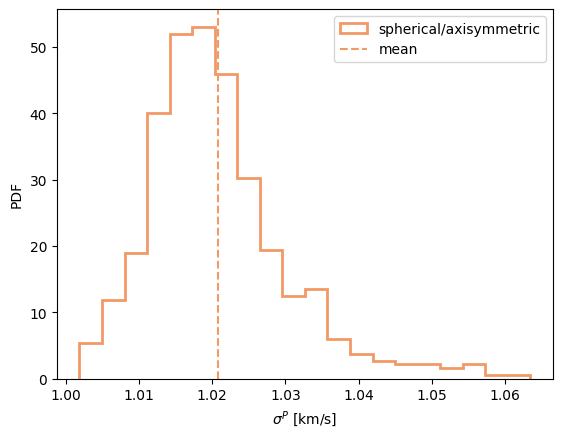

2.0746152014009938


In [9]:
plt.figure()
plt.hist(vel_disp_sph_all/sigma_e_data, density=True, lw=2, histtype='step', label = 'spherical/axisymmetric', bins=20, color=clist[2])
plt.axvline(np.mean(vel_disp_sph_all/sigma_e_data), ls = '--', color = clist[2], marker = ' ', label = 'mean')

plt.xlabel(r'$\sigma^P$ [km/s]')
plt.ylabel('PDF')
plt.legend()
plt.show()

print(percent_err(mean_vel_disp_sph_all, mean_sigma_e_data))

## Test deprojected mass distribution

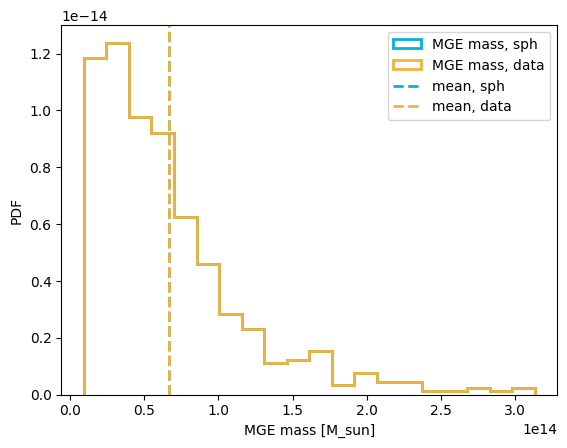

In [10]:
def total_mass(peak_den, sigma_den, Qobs, distance):
    pc = distance*np.pi/0.648
    return np.sum(2 * np.pi * peak_den * (sigma_den*pc)**2 * Qobs)

total_mass_sph_all = np.zeros_like(sigma_e_data)
for i in range(len(total_mass_sph_all)):
    total_mass_sph_all[i] = total_mass(peak_den[i], sigma_den_sph[i], 1, distance)

total_mass_axi_all = np.zeros_like(sigma_e_data)
for i in range(len(total_mass_axi_all)):
    total_mass_axi_all[i] = total_mass(peak_den[i], sigma_den[i], qobs_data[i], distance)

plt.figure()
plt.hist(total_mass_sph_all, density=True, histtype='step', lw=2, label = 'MGE mass, sph', bins=20)
plt.hist(total_mass_axi_all, density=True, histtype='step', lw=2, label = 'MGE mass, data', bins=20)
plt.axvline(np.mean(total_mass_sph_all), lw=2, ls='--', label = 'mean, sph', color=clist[0], marker = ' ')
plt.axvline(np.mean(total_mass_axi_all), lw=2, ls='--', label = 'mean, data', color=clist[1], marker = ' ')
plt.xlabel('MGE mass [M_sun]')
# plt.xscale('log')
plt.ylabel('PDF')
plt.legend()
plt.show()